In [1]:
# DISTANCE FUNCTION GENERATOR :

# Import the necessary packages :
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dist import phi
import random as rd
from tqdm import tqdm
from scipy import interpolate as int

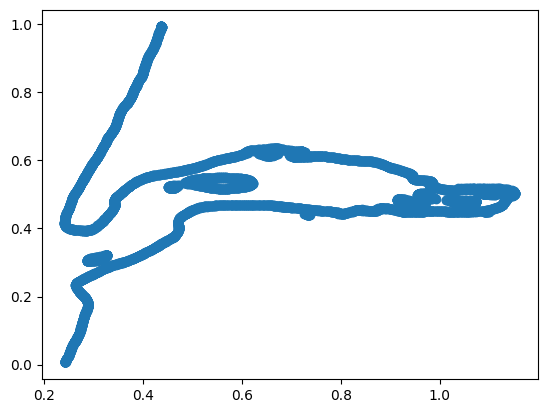

In [57]:
# Import the data :
data_frontier = pd.read_csv("../../processed_data/Domain_height_2/normalized_frontier.csv").to_numpy()
X=data_frontier[:,0]
Y=data_frontier[:,1]
plt.scatter(X,Y)

In [58]:
# create necessary functions to get the segments from the boundary :

def orga_point(X,Y,margin,ind,chosen,m) :
    """
    tries to link all the m points of (X,Y) that are not in chosen
    and that are separated from eachother by a distance smaller than margin
    starting from (X[ind],Y[ind]).
    Returns the array of coordinate Xd and Yd as well as an array of distance to each point linked dist
        Input :
            X : array of x-coordinate
            Y : array of y-coordinate
            margin : float
            ind : integer between 0 and m
            chosen : list of bool corresponding to each point of (X[i],Y[i])

    """
    x0=X[ind]
    y0=Y[ind]
    chosen[ind]=True
    dist=[0]
    Xd=[x0]
    Yd=[y0]
    done=False
    while not done :
        j=ind
        V0=np.array([x0,y0])
        done=True
        d0=np.Inf
        n_neig=0
        n_visited=0
        for i in range(X.shape[0]) :
            x=X[i]
            y=Y[i]
            V=np.array([x,y])
            d=np.linalg.norm(V-V0)
            if d<margin :
                n_neig +=1
                if (not chosen[i]) and d<d0 :
                    n_visited+=1
                    d0=d
                    j=i
        if d0 < np.Inf :
            if n_visited/n_neig < 0.1 :
                dist.append(d0)
                Xd.append(X[j])
                Yd.append(Y[j])
                x0=X[j]
                y0=Y[j]
            done=False
            chosen[j]=True
        else :
            chosen[j]=True
    return np.array(Xd),np.array(Yd),np.array(dist)

def orga_final(X,Y,margin,marginseg) :
    """
    Links most points in (X,Y) (those that are closer to eachother than marginseg are not considered)
    Returns three list of arrays : XF,YF,DIST
        Input :
            X : array of x coordinates
            Y : array of y coordinates
            margin : float
            marginseg : float
    """
    m=0
    XF=[]
    YF=[]
    DIST=[]
    chosen=[False]*(X.shape[0])
    for i in range(X.shape[0]) :
        if not chosen[i] :
            take=True
            for j in range(X.shape[0]) :
                V1=np.array([X[i],Y[i]])
                V2=np.array([X[j],Y[j]])
                if chosen[j] and np.linalg.norm(V1-V2)< marginseg :
                    take=False
                    chosen[i] = True
            if take :
                print('points remaining : ',X.shape[0]-m,' left ...')
                Xd,Yd,dist=orga_point(X,Y,margin,i,chosen,m)
                print('computing taken points...')
                if Xd.shape[0] > 10 :
                    m=0
                    for i1 in range(X.shape[0]) :
                        if not chosen[i1] :
                            for j1 in range(Xd.shape[0]) :
                                V1=np.array([X[i1],Y[i1]])
                                V2=np.array([Xd[j1],Yd[j1]])
                                if np.linalg.norm(V1-V2)< marginseg :
                                    chosen[i1] = True
                        if chosen[i1] :
                            m+=1
                    XF.append(Xd)
                    YF.append(Yd)
                    DIST.append(dist)
    return XF,YF,DIST

def cleaning_points(points,X,Y,margin) :
    """
    removes any segment that is too far from the frontier (X,Y)
        Input :
            points : an array of points
            X : array of x coordinate
            Y : array of y coordinate
            margin : float
    """
    Xs=[]
    Ys=[]
    Xd=points[:,0]
    Yd=points[:,1]
    for i in range(Xd.shape[0]) :
        Inside=False
        for j in range(X.shape[0]) :
            V=np.array([X[j],Y[j]])
            Vd=np.array([Xd[i],Yd[i]])
            Vd2=np.array([Xd[i-1],Yd[i-1]])
            if np.linalg.norm(Vd-V) < margin :
                Inside=True
        if Inside or i==1 :
            Xs.append(Xd[i])
            Ys.append(Yd[i])
        else :
            return np.array(Xs),np.array(Ys)

points remaining :  6625  left ...
computing taken points...
points remaining :  5130  left ...
computing taken points...
points remaining :  3622  left ...
computing taken points...
points remaining :  2865  left ...
computing taken points...
points remaining :  2865  left ...
computing taken points...
points remaining :  2865  left ...
computing taken points...
points remaining :  2865  left ...
computing taken points...
points remaining :  2865  left ...
computing taken points...
points remaining :  2698  left ...
computing taken points...
points remaining :  2698  left ...
computing taken points...
points remaining :  2698  left ...
computing taken points...
points remaining :  2698  left ...
computing taken points...
points remaining :  2698  left ...
computing taken points...
points remaining :  2698  left ...
computing taken points...
points remaining :  2698  left ...
computing taken points...
points remaining :  2698  left ...
computing taken points...
points remaining :  2698

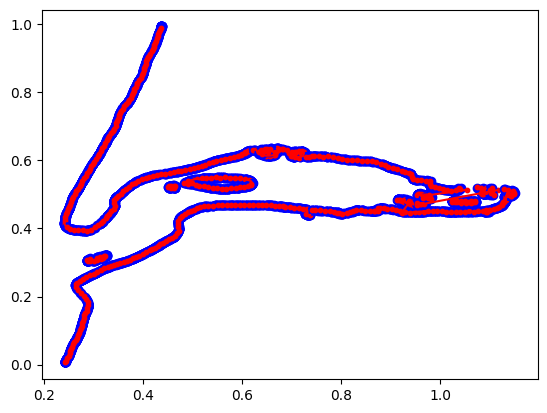

In [59]:
# reorganize the points in the frontier in order to do an interpolation :

margin=0.01
XD,YD,DIST=orga_final(X,Y,margin,margin/20)

# for each array of organized points, interpolate in order to get the splines :


Seg_coords=[]

for i in range(len(XD)) :
    print(i+1,'/',len(XD))
    Xd=XD[i]
    Yd=YD[i]
    dist=DIST[i]

    points_seg=[]

    for j in range(dist.shape[0]) :
        if dist[j] == 0 and j!=0 :
            print(j)

    distance=np.cumsum(dist)
    points=np.vstack( (Xd, Yd) ).T


    # Build a list of the spline function, one for each dimension:

    splines = [int.make_interp_spline(distance, coords, k=3) for coords in points.T]
    # splines = [int.UnivariateSpline(distance, coords, k=3, s=0.2) for coords in points.T]

    # Computed the spline for the asked distances:
    alpha = np.linspace(0, 10, 1000)
    points_fitted = np.vstack( list(spl(alpha) for spl in splines) ).T

    print('cleaning points...')
    Xs,Ys=cleaning_points(points_fitted,X,Y,margin/2)
    print('done')


    plt.scatter(Xd,Yd,c='b')
    plt.scatter(Xs,Ys,s=10,c='r')
    plt.plot(Xs,Ys,c='r')
        
    for j in range(Xs.shape[0]) :
        x=Xs[j]
        y=Ys[j]
        points_seg.append([x,y])
    Seg_coords.append(points_seg)
plt.show()

100%|██████████| 20/20 [00:00<00:00, 20145.55it/s]


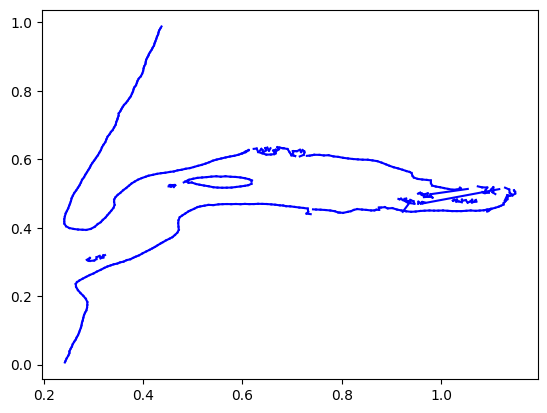

FileNotFoundError: [Errno 2] No such file or directory: 'dist/saves/arcachon_segment_TEMP.npy'

In [63]:
def seg_gen(listofcoords) :
    seg=[]
    for i in range(len(listofcoords)-1) :
        seg.append([listofcoords[i][0],listofcoords[i][1],listofcoords[i+1][0],listofcoords[i+1][1]])
    return np.array(seg)

# concatenate arrays of segments :



Seg_final=[]
for i1 in tqdm(range(len(Seg_coords))) :
    listofcoords=Seg_coords[i1]
    seg=seg_gen(listofcoords)
    for e in seg :
        Seg_final.append(e)
    # for i2 in range(i1+1,len(Seg_coords)) :
    #     listofcoords2=Seg_coords[i2]
    #     P10=np.array(listofcoords[0])
    #     P1n=np.array(listofcoords[-1])
    #     P20=np.array(listofcoords2[0])
    #     P2n=np.array(listofcoords2[-1])
    #     if np.linalg.norm(P10-P20)<margin :
    #         Seg_final.append([P10[0],P10[1],P20[0],P20[1]])
    #     if np.linalg.norm(P10-P2n)<margin :
    #         Seg_final.append([P10[0],P10[1],P2n[0],P2n[1]])           
    #     if np.linalg.norm(P1n-P20)<margin :
    #         Seg_final.append([P1n[0],P1n[1],P20[0],P20[1]])
    #     if np.linalg.norm(P1n-P2n)<margin :
    #         Seg_final.append([P1n[0],P1n[1],P2n[0],P2n[1]])

for i in range(len(Seg_final)) :
    segment=Seg_final[i]
    x1=segment[0]
    y1=segment[1]
    x2=segment[2]
    y2=segment[3]
    plt.plot([x1,x2],[y1,y2],c='b')
plt.show()

# save the segments :

np.save('saves/arcachon_segment_TEMP',Seg_final)

100%|██████████| 515/515 [00:08<00:00, 63.92it/s]


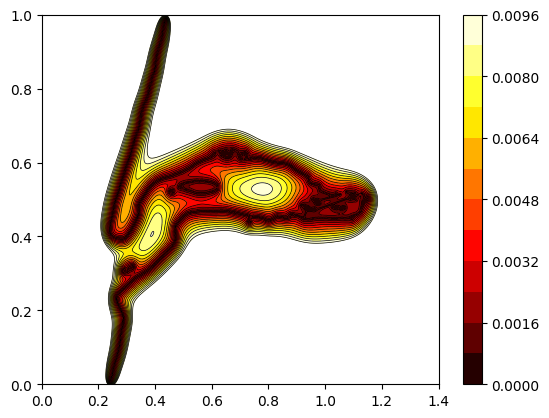

In [61]:
# compute distance function :

n=500

x=np.linspace(0,1.4,n)
y=np.linspace(0,1,n)[::-1]
X,Y = np.meshgrid(x, y)

Z = phi(X,Y,np.array(Seg_final))

levels = np.arange(0,0.01,0.0008)
cset = plt.contourf(X,Y,Z,levels=levels,cmap='hot')
cset2 = plt.contour(X,Y,Z,levels=levels,colors='k',linewidths=0.5)
plt.colorbar(cset)

plt.show()